### Data Loading  

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [34]:
df_aep = pd.read_csv('AEP_hourly.csv')
df_aep

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [35]:
df_aep['Datetime'] = pd.to_datetime(df_aep['Datetime'])

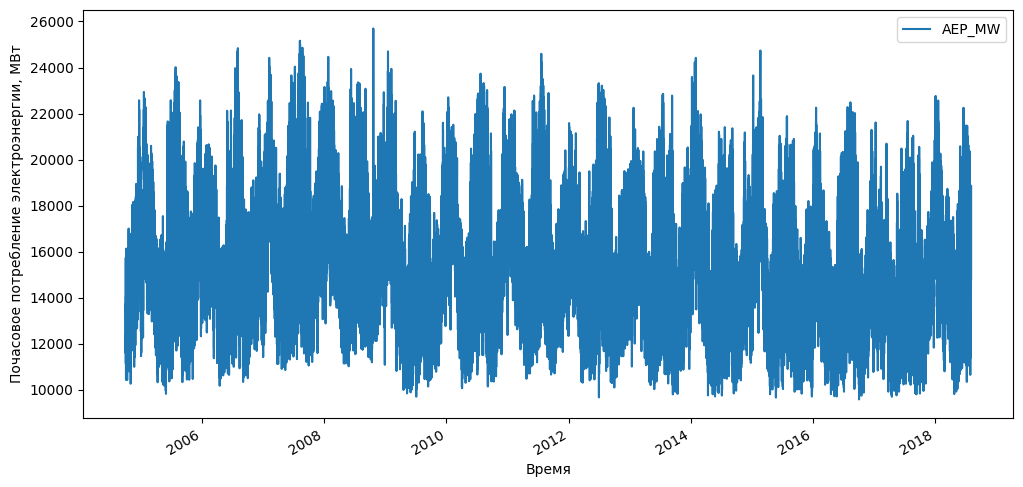

In [36]:
df_aep.plot(x='Datetime', y='AEP_MW', figsize=(12, 6))
plt.xlabel('Время')
plt.ylabel('Почасовое потребление электроэнергии, МВт')
plt.show()

### Feature engeenering

In [37]:
df_aep['lag 1h'] = df_aep['AEP_MW'].shift(1)
df_aep['lag 24h'] = df_aep['AEP_MW'].shift(24)
df_aep['mean 24h'] = df_aep['lag 1h'].rolling(window=24, min_periods=1).mean()
df_aep['mean 7d'] = df_aep['lag 1h'].rolling(window=168, min_periods=1).mean()
print(df_aep[['Datetime', 'AEP_MW', 'lag 1h', 'mean 24h', 'mean 7d']].head(3))

             Datetime   AEP_MW   lag 1h  mean 24h  mean 7d
0 2004-12-31 01:00:00  13478.0      NaN       NaN      NaN
1 2004-12-31 02:00:00  12865.0  13478.0   13478.0  13478.0
2 2004-12-31 03:00:00  12577.0  12865.0   13171.5  13171.5


In [38]:
df_aep['hour'] = df_aep['Datetime'].dt.hour
df_aep['weekday'] = df_aep['Datetime'].dt.weekday
df_aep['month'] = df_aep['Datetime'].dt.month
df_aep['day'] = df_aep['Datetime'].dt.day
df_aep['year'] = df_aep['Datetime'].dt.year
df_aep['season'] = (df_aep['month'] % 12 + 3) // 3
df_aep['is_weekend'] = (df_aep['weekday'] >= 5).astype(int)

In [39]:
# cyclic features
df_aep['hour_cos'] = np.cos(2 * np.pi * df_aep['hour'] / 24)
df_aep['hour_sin'] = np.sin(2 * np.pi * df_aep['hour'] / 24)

df_aep['day_cos'] = np.cos(2 * np.pi * df_aep['day'] / 31)
df_aep['day_sin'] = np.sin(2 * np.pi * df_aep['day'] / 31)

df_aep['weekday_cos'] = np.cos(2 * np.pi * df_aep['weekday'] / 7)
df_aep['weekday_sin'] = np.sin(2 * np.pi * df_aep['weekday'] / 7)

df_aep['month_cos'] = np.cos(2 * np.pi * df_aep['month'] / 12)
df_aep['month_sin'] = np.sin(2 * np.pi * df_aep['month'] / 12)

In [40]:
df_aep

,Datetime,AEP_MW,lag 1h,lag 24h,mean 24h,mean 7d,hour,weekday,month,day,year,season,is_weekend,hour_cos,hour_sin,day_cos,day_sin,weekday_cos,weekday_sin,month_cos,month_sin
0,2004-12-31 01:00:00,13478.0,NaN,NaN,NaN,NaN,1,4,12,31,2004,1,0,0.965926,0.258819,1.000000,-2.449294e-16,-0.900969,-0.433884,1.000000,-2.449294e-16
1,2004-12-31 02:00:00,12865.0,13478.0,NaN,13478.000000,13478.000000,2,4,12,31,2004,1,0,0.866025,0.500000,1.000000,-2.449294e-16,-0.900969,-0.433884,1.000000,-2.449294e-16
2,2004-12-31 03:00:00,12577.0,12865.0,NaN,13171.500000,13171.500000,3,4,12,31,2004,1,0,0.707107,0.707107,1.000000,-2.449294e-16,-0.900969,-0.433884,1.000000,-2.449294e-16
3,2004-12-31 04:00:00,12517.0,12577.0,NaN,12973.333333,12973.333333,4,4,12,31,2004,1,0,0.500000,0.866025,1.000000,-2.449294e-16,-0.900969,-0.433884,1.000000,-2.449294e-16
4,2004-12-31 05:00:00,12670.0,12517.0,NaN,12859.250000,12859.250000,5,4,12,31,2004,1,0,0.258819,0.965926,1.000000,-2.449294e-16,-0.900969,-0.433884,1.000000,-2.449294e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,20925.0,21971.0,19747.958333,20393.440476,20,0,1,1,2018,1,0,0.500000,-0.866025,0.979530,2.012985e-01,1.000000,0.000000,0.866025,5.000000e-01
121269,2018-01-01 21:00:00,20999.0,21089.0,21942.0,19711.208333,20407.464286,21,0,1,1,2018,1,0,0.707107,-0.707107,0.979530,2.012985e-01,1.000000,0.000000,0.866025,5.000000e-01
121270,2018-01-01 22:00:00,20820.0,20999.0,21695.0,19671.916667,20423.065476,22,0,1,1,2018,1,0,0.866025,-0.500000,0.979530,2.012985e-01,1.000000,0.000000,0.866025,5.000000e-01
121271,2018-01-01 23:00:00,20415.0,20820.0,21230.0,19635.458333,20441.000000,23,0,1,1,2018,1,0,0.965926,-0.258819,0.979530,2.012985e-01,1.000000,0.000000,0.866025,5.000000e-01


In [41]:
df_aep.isna().sum().sum()

27

In [42]:
df_aep = df_aep.dropna()

In [43]:
X_aep = df_aep.drop(['Datetime', 'AEP_MW'], axis=1)
y_aep = df_aep['AEP_MW']

In [44]:
X_aep_train = X_aep[df_aep['Datetime'] < '2017-01-01']
y_aep_train = y_aep[df_aep['Datetime'] < '2017-01-01']

X_aep_test = X_aep[df_aep['Datetime'] >= '2017-01-01']
y_aep_test = y_aep[df_aep['Datetime'] >= '2017-01-01']

In [45]:
aep_scaler = StandardScaler().set_output(transform='pandas')

X_aep_train_scaled = aep_scaler.fit_transform(X_aep_train)
X_aep_test_scaled = aep_scaler.transform(X_aep_test)

In [46]:
params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
}
scoring = 'neg_mean_squared_error'
cv = 10

tscv = TimeSeriesSplit(n_splits=cv)

cv_ridge_aep = GridSearchCV(
    estimator=Ridge(random_state=55),
    param_grid=params,
    scoring=scoring,
    cv=tscv,
    n_jobs=-1
).fit(X_aep_train_scaled, y_aep_train)

In [47]:
# with optimal hyperparameters

ridge_aep = Ridge(alpha=cv_ridge_aep.best_params_['alpha'], random_state=55)
ridge_aep.fit(X_aep_train_scaled, y_aep_train)

y_aep_pred = ridge_aep.predict(X_aep_test_scaled)

print("Ridge Regression Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_aep_test, y_aep_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_aep_test, y_aep_pred):.2f}")
print(f"R^2 Score: {r2_score(y_aep_test, y_aep_pred):.4f}")

Ridge Regression Performance on Test Set:
Mean Absolute Error (MAE): 334.92
Mean Squared Error (MSE): 213440.51
R^2 Score: 0.9631


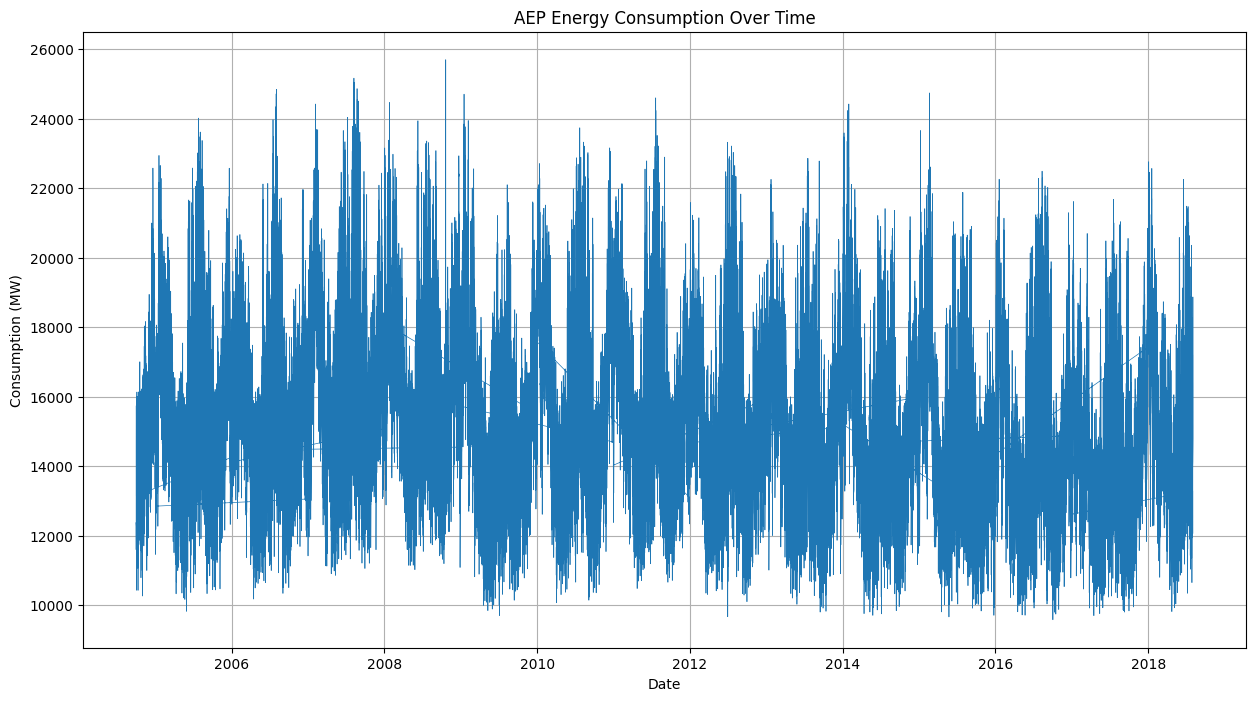

In [48]:
plt.figure(figsize=(15, 8))
plt.plot(df_aep['Datetime'], df_aep['AEP_MW'], linewidth=0.5)
plt.title('AEP Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.grid(True)
plt.show()

In [49]:
feature_importance = pd.DataFrame({
    'feature': X_aep_train.columns,
    'coefficient': ridge_aep.coef_,
    'abs_importance': np.abs(ridge_aep.coef_)
}).sort_values('abs_importance', ascending=False)

print("Top-15 most important features:")
print(feature_importance.head(15))

Top-15 most important features:
        feature  coefficient  abs_importance
0        lag 1h  2084.821324     2084.821324
1       lag 24h   480.611571      480.611571
12     hour_sin   229.061978      229.061978
11     hour_cos  -220.773052      220.773052
4          hour   187.666133      187.666133
5       weekday  -176.856812      176.856812
15  weekday_cos  -171.108004      171.108004
16  weekday_sin   -92.916429       92.916429
18    month_sin   -31.341782       31.341782
9        season   -30.731473       30.731473
3       mean 7d   -18.433413       18.433413
6         month   -16.301174       16.301174
7           day    13.664174       13.664174
8          year   -10.048600       10.048600
14      day_sin     8.757870        8.757870


In [50]:
lag_features = [col for col in X_aep_train.columns if 'lag' in col]
rolling_features = [col for col in X_aep_train.columns if 'mean' in col]
time_features = [col for col in X_aep_train.columns if any(x in col for x in ['hour', 'day', 'month', 'year'])]
cyclic_features = [col for col in X_aep_train.columns if any(x in col for x in ['_sin', '_cos'])]

# average importance by feature groups
feature_groups = {
    'Lags': lag_features,
    'Rolling means': rolling_features, 
    'Time features': time_features,
    'Cyclic features': cyclic_features
}

for group_name, features in feature_groups.items():
    if features:
        group_importance = feature_importance[feature_importance['feature'].isin(features)]['abs_importance'].mean()
        print(f"Average importance {group_name}: {group_importance:.4f}")

Average importance Lags: 1282.7164
Average importance Rolling means: 10.3789
Average importance Time features: 89.6435
Average importance Cyclic features: 95.1036


In [51]:
# Разбиваем тестовую выборку на периоды
test_dates = df_aep.loc[y_aep_test.index, 'Datetime']

# По годам
for year in test_dates.dt.year.unique():
    year_mask = test_dates.dt.year == year
    year_rmse = mean_squared_error(y_aep_test[year_mask], y_aep_pred[year_mask])**0.5
    print(f"RMSE за {year} год: {year_rmse:.2f} МВт")

# По сезонам
def get_season(month):
    if month in [12, 1, 2]: return 'Зима'
    elif month in [3, 4, 5]: return 'Весна'
    elif month in [6, 7, 8]: return 'Лето'
    else: return 'Осень'

test_seasons = test_dates.dt.month.apply(get_season)
for season in test_seasons.unique():
    season_mask = test_seasons == season
    season_rmse = mean_squared_error(y_aep_test[season_mask], y_aep_pred[season_mask])**0.5
    print(f"RMSE за {season}: {season_rmse:.2f} МВт")

RMSE за 2017 год: 447.08 МВт
RMSE за 2018 год: 486.39 МВт
RMSE за Зима: 586.14 МВт
RMSE за Осень: 397.11 МВт
RMSE за Лето: 409.58 МВт
RMSE за Весна: 417.29 МВт
